# Evaluation Criteria Rationale

Our key evaluation metrics are processing time and token usage. 

In this notebook, we show that time per output token ($tpot$) multiplied by the number of output tokens ($n$) ($tpot * n$) is a reasonable estimation for the processing time.

## Define Measurement Function

In [273]:
import time

def measure_ttft_tpot(llm, prompt):
    """Measure Time To First Token and Time Per Output Token for a given prompt."""
    start = time.time()
    ttft = None
    tpot = []
    i = 0
    for chunk in llm.stream(prompt):
        if i == 0:
            ttft = time.time() - start  # Time To First Token
        else:
            tpot.append(time.time() - start)  # Time Per Output Token
        start = time.time()
        i += 1
    avg_tpot = sum(tpot) / len(tpot) # Average Time Per Output Token
    ttft = ttft - avg_tpot # Adjusting for the first token

    print(f'TTFT: {ttft:.4f}')
    print(f'AVG TPOT: {avg_tpot:.4f}')
    

## Prompts

In [296]:
from faker import Faker

fake = Faker()

# Generate a paragraph with a specific number of words
paragraph = fake.text(max_nb_chars=1000)

prompt_short = fake.text(max_nb_chars=100)
prompt_medium = fake.text(max_nb_chars=1000)
prompt_long = fake.text(max_nb_chars=10000)


## TTFT & TPOT OpenAI

In [275]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", max_tokens=10, temperature=0)

In [276]:
measure_ttft_tpot(llm, prompt_short)

TTFT: 0.6365
AVG TPOT: 0.0088


In [277]:
measure_ttft_tpot(llm, prompt_medium)

TTFT: 0.4181
AVG TPOT: 0.0115


In [278]:
measure_ttft_tpot(llm, prompt_long)

TTFT: 0.4626
AVG TPOT: 0.0147


## TTFT & TPOT Ollama

In [279]:
from langchain_ollama import OllamaLLM

llm = OllamaLLM(model="phi3.5", num_predict=10, keep_alive=180, temperature=0)

_ = llm.invoke("The cat jumped quickly over the wooden fence.") # Load the model in GPU

In [280]:
measure_ttft_tpot(llm, prompt_short)

TTFT: 0.1611
AVG TPOT: 0.0183


In [281]:
measure_ttft_tpot(llm, prompt_medium)

TTFT: 0.5449
AVG TPOT: 0.0206


In [282]:
measure_ttft_tpot(llm, prompt_long)

TTFT: 5.3950
AVG TPOT: 0.0291


## Display TPOT

In [349]:
import time
import matplotlib.pyplot as plt

def plot_tpot(llm, prompt, title_suffix: str=""):
    # Initialize list to store time metrics
    tpot = []    # Time Per Output Token (after the first one)
    i = 0
    start = time.time()

    # Stream the response and capture timing
    for chunk in llm.stream(prompt):
        if i == 0:
            pass # Time To First Token
        else:
            tpot.append(time.time() - start)  # Time Per Output Token
        start = time.time()
        i += 1

    # Plotting TTFT and TPOT
    if tpot is not None:
        plt.figure(figsize=(10, 5), dpi=300)


        # Plot TPOT
        plt.bar(range(1, len(tpot)+1), tpot, color='blue', label='TPOT')

        # Calculate and plot the average TPOT
        if len(tpot) > 0:
            avg_tpot = sum(tpot) / len(tpot)
            plt.axhline(y=avg_tpot, color='red', linestyle='--', label=f'Average TPOT: {avg_tpot:.4f} s')

        # Adding labels and title
        plt.xlabel("Token")
        plt.ylabel("Time (s)")
        plt.title(f"Time Per Output Token (TPOT){title_suffix}")
        plt.legend()

        # Show the plot
        plt.show()


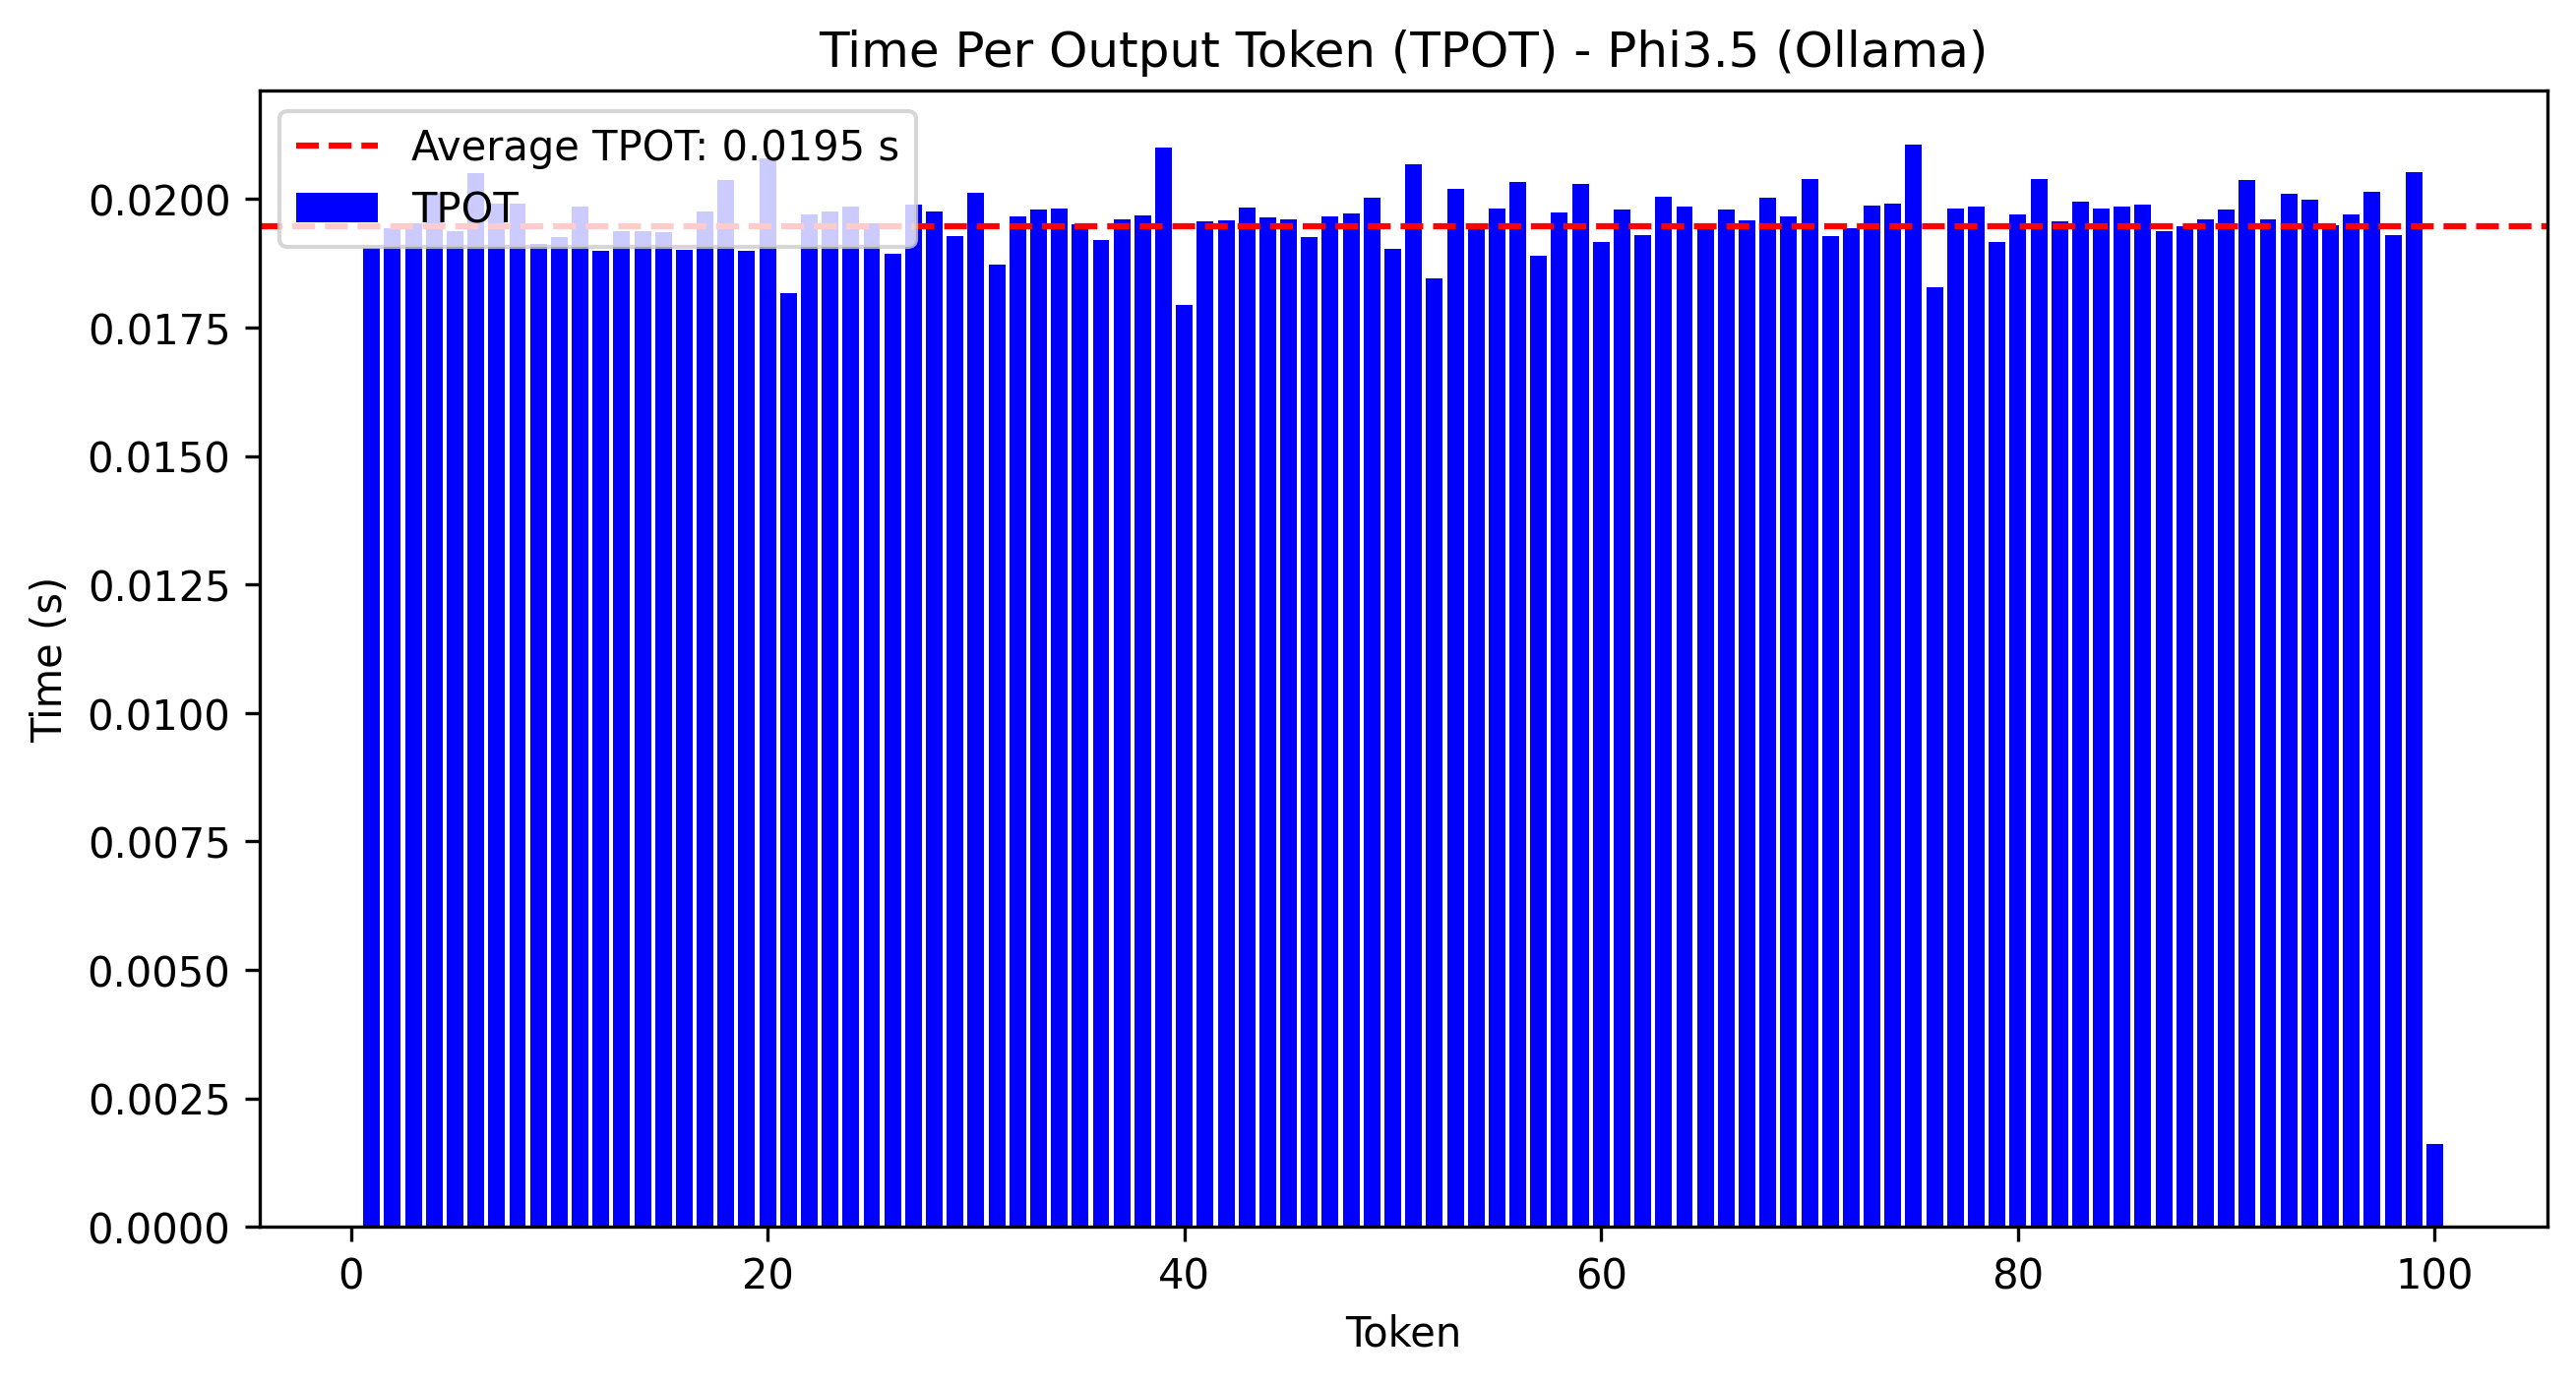

In [352]:
from langchain_ollama import OllamaLLM

llm = OllamaLLM(model="phi3.5", num_predict=100, keep_alive=180, temperature=0)

plot_tpot(llm, prompt_short, ' - Phi3.5 (Ollama)')

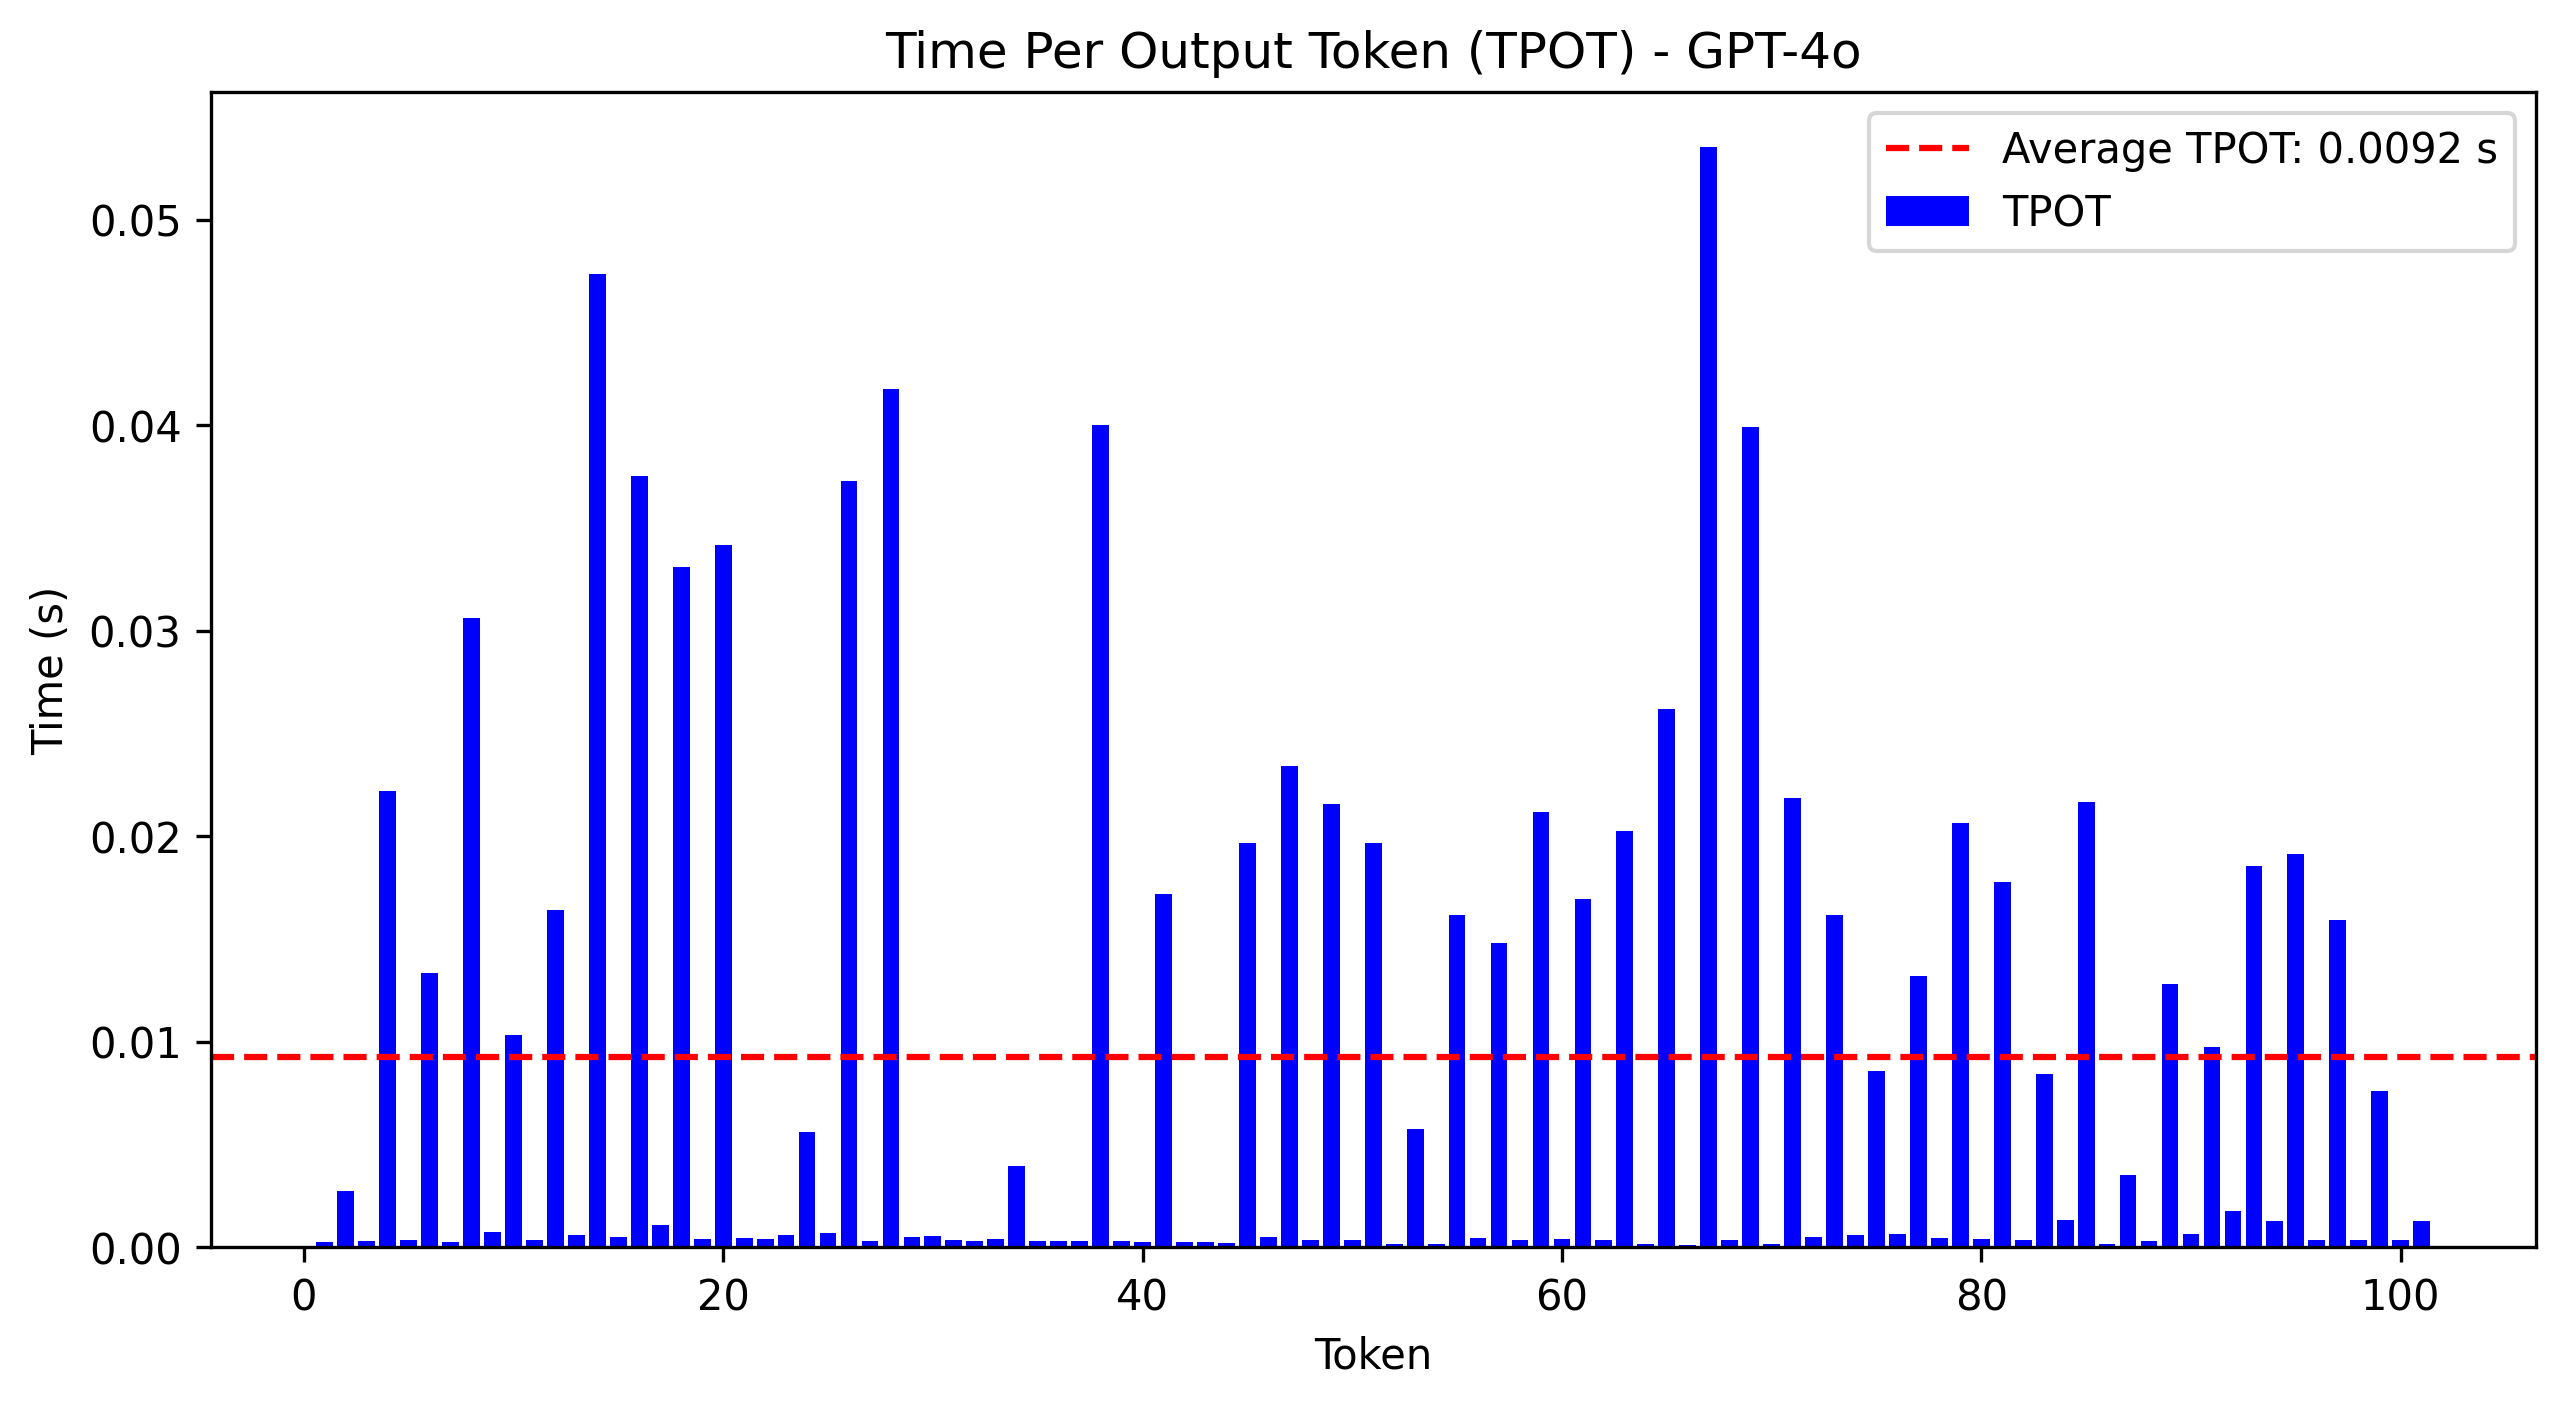

In [353]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", max_tokens=100, temperature=0)

plot_tpot(llm, prompt_short, ' - GPT-4o')